In [1]:
pip install praat-textgrids

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
import math
import os.path
import os
import librosa
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import librosa.display
import sys, re
from tqdm import tqdm


In [40]:
#-------------------------------------------------
# Text file input / output

def inputtextlines(filename):
    handle = open(filename,'r')
    linelist = handle.readlines()
    handle.close()
    return linelist

def outputtext(filename, text):
    handle = open(filename,'w')
    handle.write(text)
    handle.close()

#-------------------------------------------------
# Conversion routines


def converttextgrid2csv(textgridlines,textgridname):

    # csvtext = '# TextGrid to CSV (D. Gibbon, 2008-11-23)\n# Open the file with OpenOffice.org Calc or MS-Excel.\nFileName\tTierType\tTierName\tLabel\tStart\tEnd\tDuration\n'
    csvtext = ''
    newtier = False
    start = []
    end = []
    durr = []
    file = []
    for line in textgridlines[9:]:
        line = re.sub('\n','',line)
        line = re.sub('^ *','',line)
        linepair = line.split(' = ')
        if len(linepair) == 2:
            # if linepair[0] == 'class':
            #     classname = linepair[1]
            # if linepair[0] == 'name':
            #     tiername = linepair[1]
            if linepair[0] == 'xmin':
                xmin = linepair[1]
            if linepair[0] == 'xmax':
                xmax = linepair[1]
            if linepair[0] == 'text':
                text = linepair[1]
                if (text=="\"1\"" + " "):
                  start.append(float(xmin))
                  end.append(float(xmax))
                  diff = str(float(xmax)-float(xmin))
                  durr.append(float(diff))
                  file.append(textgridname)
                # csvtext += text + '\t' + xmin + '\t' + xmax + '\t' + diff + '\n'
    return start,end,durr,file

In [41]:
def load_annotations(path):
  textgridname = path
  textgrid = inputtextlines(textgridname)
  start,end,durr,file = converttextgrid2csv(textgrid,textgridname)
  df = pd.DataFrame()
  df['start'] = start
  df['end'] = end
  df['duration'] = durr
  df['file'] = file
  df['event'] = 'yes'
  return df

annotations = load_annotations("/content/gdrive/MyDrive/EE798/Data/Annotation/Female/PTDB-TUG/mic_F01_sa2.TextGrid")
annotations


,start,end,duration,file,event
0,3.300,3.980,0.680,/content/gdrive/MyDrive/EE798/Data/Annotation/...,yes
1,4.124,5.396,1.272,/content/gdrive/MyDrive/EE798/Data/Annotation/...,yes
2,5.500,5.740,0.240,/content/gdrive/MyDrive/EE798/Data/Annotation/...,yes


In [15]:
annotations.event.value_counts()

yes    3
Name: event, dtype: int64

In [61]:
# input
audio_path = '/content/gdrive/MyDrive/EE798/Data/Audio/Female/PTDB-TUG/mic_F01_sa2.wav'
annotations_path = '/content/gdrive/MyDrive/EE798/Data/Annotation/Female/PTDB-TUG/mic_F01_sa2.TextGrid'

# samplerate to process at
samplerate = 16000

# temporal resolution, both for spectrogram and prediction output
time_resolution = 0.30

# how much data to use for
val_size = 0.15
test_size = 0.15


In [62]:
def next_power_of_2(x):
    return 2**(math.ceil(math.log(x, 2)))

hop_length = int(time_resolution*samplerate)
n_fft = next_power_of_2(hop_length)

print(hop_length, n_fft)

4800 8192


In [63]:
def load_spectrogram(path, sr=16000, n_mels=32, n_fft=1024, hop_length=512):
    y, sr = librosa.load(path, sr=sr)

    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, n_mels=n_mels, hop_length=hop_length)
    db = librosa.power_to_db(S, ref=0.0)

    return db


spec = load_spectrogram(audio_path, hop_length=hop_length, n_fft=n_fft)
spec.shape

(32, 25)

In [64]:
def make_continious_labels(events, length, time_resolution):
    """
    Create a continious vector for the event labels that matches the time format of our spectrogram

    Assumes that no annotated event means nothing occurred.
    """

    freq = pd.Timedelta(seconds=time_resolution)

    # Create empty covering entire spectrogram
    duration = length * time_resolution
    ix = pd.timedelta_range(start=pd.Timedelta(seconds=0.0),
                    end=pd.Timedelta(seconds=duration),
                    freq=freq,
                    closed='left',
    )
    ix.name = 'time'
    df = pd.DataFrame({}, index=ix)
    assert len(df) == length, (len(df), length)
    df["event"] = 0

    # fill in event data
    for start, end in zip(events['start'], events['end']):
        # print(start)
        s = pd.Timedelta(start, unit='s')
        e = pd.Timedelta(end, unit='s')

        # XXX: focus just on onsets
        e = s + pd.Timedelta(0.300, unit='s')

        # print(s,e)
        match = df.loc[s:e]
        # print(match)
        df.loc[s:e, "event"] = 1

    return df

l = make_continious_labels(annotations, spec.shape[1], time_resolution)
l.event.value_counts()

0    23
1     2
Name: event, dtype: int64

In [ ]:
l

In [65]:
window_duration = 0.901
window_length = int(window_duration / time_resolution)
window_length

3

In [47]:
# extract overlapped time-windows for spectrograms and labels
def compute_windows(arr, frames, pad_value=0.0, overlap=0.5, step=None):
    if step is None:
        step = int(frames * (1-overlap))

    windows = []
    index = []

    width, length = arr.shape

    for start_idx in range(0, length, step):
        end_idx = min(start_idx + frames, length)

        # create emmpty
        win = np.full((width, frames), pad_value, dtype=float)
        # fill with data
        win[:, 0:end_idx-start_idx] = arr[:,start_idx:end_idx]

        windows.append(win)
        index.append(start_idx)

    s = pd.Series(windows, index=index)
    s.index.name = 'start_index'
    return s

# windows = pd.DataFrame({
#     'spectrogram': compute_windows(spec, frames=window_length, step=2),
#     'labels': compute_windows(l.values.T, frames=window_length, step=2),
#     'file': audio_path,
# })
# windows['event'] = windows.labels.apply(lambda labels:  np.any(labels, axis=-1)).astype(int)
# windows[windows.event == True].head(5)

In [66]:
i = 0
folder_path = '/content/gdrive/MyDrive/EE798/Data/Annotation/Female/PTDB-TUG'
folder_path2 = '/content/gdrive/MyDrive/EE798/Data/Audio/Female/PTDB-TUG'

# List files in the folder
files = os.listdir(folder_path)

# Process the files
for file_name in files:

  audio_path = folder_path2 + "/" + file_name.split(".")[0] + ".wav"
  annotations_path = folder_path + "/" + file_name

  # if (i==0):
  #   annotations = load_annotations(annotations_path)
  # else:
  #   annotation = load_annotations(annotations_path)
  #   annotations = annotations.append(annotation, ignore_index = True)
  # i = i +1

  spec = load_spectrogram(audio_path, hop_length=hop_length, n_fft=n_fft)
  l = make_continious_labels(annotations, spec.shape[1], time_resolution)
  if (i==0):
    windows = pd.DataFrame({
        'spectrogram': compute_windows(spec, frames=window_length, step=2),
        'labels': compute_windows(l.values.T, frames=window_length, step=2),
        'file': audio_path,
    })
    windows['event'] = windows.labels.apply(lambda labels: np.any(labels, axis=-1)).astype(int)
    windows[windows.event == True]
    # print(len(windows))
  else:
    window = pd.DataFrame({
        'spectrogram': compute_windows(spec, frames=window_length, step=2),
        'labels': compute_windows(l.values.T, frames=window_length, step=2),
        'file': audio_path,
    })
    window['event'] = window.labels.apply(lambda labels: np.any(labels, axis=-1)).astype(int)
    window[window.event == True]
    windows = windows.append(window, ignore_index = True)
    # print(len(window))
  i = i + 1

AssertionError: ignored

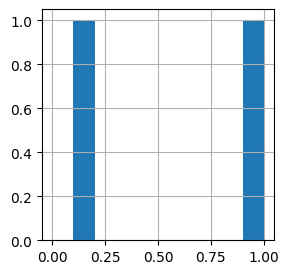

In [67]:
annotations.duration.hist(width=0.10, range=(0, 1.0), figsize=(3, 3))
plt.savefig("figure5.jpeg",dpi=800)

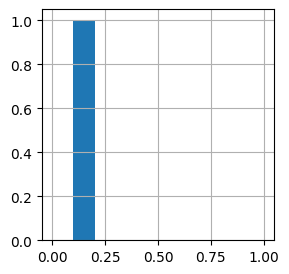

In [68]:
(annotations['start'] - (annotations['end'].shift(1))).hist(width=0.1, range=(0, 1.0), figsize=(3, 3))
plt.savefig("figure5.jpeg",dpi=800)


In [69]:
folder_path = '/content/gdrive/MyDrive/EE798/Data/Annotation/Female/TMIT'
folder_path2 = '/content/gdrive/MyDrive/EE798/Data/Audio/Female/TMIT'

# List files in the folder
files = os.listdir(folder_path)

# Process the files
for file_name in files:

  audio_path = folder_path2 + "/" + file_name.split(".")[0] + ".wav"
  annotations_path = folder_path + "/" + file_name

  annotations = load_annotations(annotations_path)
  spec = load_spectrogram(audio_path, hop_length=hop_length, n_fft=n_fft)
  l = make_continious_labels(annotations, spec.shape[1], time_resolution)
  window = pd.DataFrame({
      'spectrogram': compute_windows(spec, frames=window_length, step=2),
      'labels': compute_windows(l.values.T, frames=window_length, step=2),
      'file': audio_path,
  })
  window['event'] = window.labels.apply(lambda labels: np.any(labels, axis=-1)).astype(int)
  window[window.event == True]
  windows = windows.append(window, ignore_index = True)
  i = i + 1

<ipython-input-69-56641d513ca7>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  windows = windows.append(window, ignore_index = True)
<ipython-input-69-56641d513ca7>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  windows = windows.append(window, ignore_index = True)


AssertionError: ignored

In [70]:
folder_path = '/content/gdrive/MyDrive/EE798/Data/Annotation/Male/PTDB-TUG'
folder_path2 = '/content/gdrive/MyDrive/EE798/Data/Audio/Male/PTDB-TUG'

# List files in the folder
files = os.listdir(folder_path)

# Process the files
for file_name in files:

  audio_path = folder_path2 + "/" + file_name.split(".")[0] + ".wav"
  annotations_path = folder_path + "/" + file_name

  annotations = load_annotations(annotations_path)
  spec = load_spectrogram(audio_path, hop_length=hop_length, n_fft=n_fft)
  l = make_continious_labels(annotations, spec.shape[1], time_resolution)
  window = pd.DataFrame({
      'spectrogram': compute_windows(spec, frames=window_length, step=2),
      'labels': compute_windows(l.values.T, frames=window_length, step=2),
      'file': audio_path,
  })
  window['event'] = window.labels.apply(lambda labels: np.any(labels, axis=-1)).astype(int)
  window[window.event == True]
  windows = windows.append(window, ignore_index = True)
  i = i + 1

AssertionError: ignored

In [71]:
folder_path = '/content/gdrive/MyDrive/EE798/Data/Annotation/Male/TMIT'
folder_path2 = '/content/gdrive/MyDrive/EE798/Data/Audio/Male/TMIT'

# List files in the folder
files = os.listdir(folder_path)

# Process the files
for file_name in files:

  audio_path = folder_path2 + "/" + file_name.split(".")[0] + ".wav"
  annotations_path = folder_path + "/" + file_name

  annotations = load_annotations(annotations_path)
  spec = load_spectrogram(audio_path, hop_length=hop_length, n_fft=n_fft)
  l = make_continious_labels(annotations, spec.shape[1], time_resolution)
  window = pd.DataFrame({
      'spectrogram': compute_windows(spec, frames=window_length, step=2),
      'labels': compute_windows(l.values.T, frames=window_length, step=2),
      'file': audio_path,
  })
  window['event'] = window.labels.apply(lambda labels: np.any(labels, axis=-1)).astype(int)
  window[window.event == True]
  windows = windows.append(window, ignore_index = True)

<ipython-input-71-a4dfdd822277>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  windows = windows.append(window, ignore_index = True)
<ipython-input-71-a4dfdd822277>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  windows = windows.append(window, ignore_index = True)
<ipython-input-71-a4dfdd822277>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  windows = windows.append(window, ignore_index = True)
<ipython-input-71-a4dfdd822277>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  windows = windows.append(window, ignore_index = True)
<ipython-input-71-a4dfdd822277>:23: FutureWarning: The frame.append method is deprecated and will be

AssertionError: ignored

In [72]:
len(windows)

3594

In [73]:
windows = windows.sample(frac = 1)

In [74]:
def dataset_split_sequentially(data, val_size=0.15, test_size=0.15, random_state=3, column='split'):
    """
    Split DataFrame into 3 non-overlapping parts: train,val,test
    with specified proportions

    Returns a new DataFrame with the rows marked by the assigned split in @column
    """
    train_size = (1.0 - val_size - test_size)

    train_stop = int(len(data) * train_size)
    val_stop = train_stop + int(len(data)*val_size)

    train_idx = data.index[0:train_stop]
    val_idx = data.index[train_stop:val_stop]
    test_idx = data.index[val_stop:-1]

    data = data.copy()
    data.loc[train_idx, column] = 'train'
    data.loc[val_idx, column] = 'val'
    data.loc[test_idx, column] = 'test'

    return data

dataset = dataset_split_sequentially(windows, val_size=val_size, test_size=test_size)
dataset.split.value_counts()

train    2515
val       539
test      539
Name: split, dtype: int64

In [91]:
import tensorflow.keras

def weighted_binary_crossentropy(zero_weight, one_weight):
    """
    Loss with support for specifying class weights
    """
    import tensorflow.keras.backend as K

    def weighted_binary_crossentropy(y_true, y_pred):

        # standard cross entropy
        b_ce = K.binary_crossentropy(y_true, y_pred)

        # apply weighting
        weight_vector = y_true * one_weight + (1 - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy

def build_sednet(input_shape, filters=128, cnn_pooling=(5, 2, 2), rnn_units=(32, 32), dense_units=(32,), n_classes=1, dropout=0.5):
    """
    SEDnet type model

    Based https://github.com/sharathadavanne/sed-crnn/blob/master/sed.py
    """

    from tensorflow.keras import Model
    from tensorflow.keras.layers import Input, Bidirectional, Conv2D, BatchNormalization, Activation, \
            Dense, MaxPooling2D, Dropout, Permute, Reshape, GRU, TimeDistributed

    spec_start = Input(shape=(input_shape[-3], input_shape[-2], input_shape[-1]))
    spec_x = spec_start
    for i, pool in enumerate(cnn_pooling):
        spec_x = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(spec_x)
        spec_x = BatchNormalization(axis=1)(spec_x)
        spec_x = Activation('relu')(spec_x)
        spec_x = MaxPooling2D(pool_size=(1, pool))(spec_x)
        spec_x = Dropout(dropout)(spec_x)
    spec_x = Permute((2, 1, 3))(spec_x)
    spec_x = Reshape((input_shape[-3], -1))(spec_x)

    for units in rnn_units:
        spec_x = Bidirectional(
            GRU(units, activation='tanh', dropout=dropout, recurrent_dropout=dropout, return_sequences=True),
            merge_mode='mul')(spec_x)

    for units in dense_units:
        spec_x = TimeDistributed(Dense(units))(spec_x)
        spec_x = Dropout(dropout)(spec_x)

    spec_x = TimeDistributed(Dense(n_classes))(spec_x)
    out = Activation('sigmoid', name='strong_out')(spec_x)

    model = Model(inputs=spec_start, outputs=out)

    return model

def build_model(input_shape, dropout=0.5, lr=0.01, class_weights=None):

    # Model
    model = build_sednet(input_shape, n_classes=1,
                         filters=10,
                         cnn_pooling=[2, 2, 2],
                         rnn_units=[5, 5],
                         dense_units=[16],
                         dropout=dropout,
                        )

    # Metrics
    pr_auc = tensorflow.keras.metrics.AUC(num_thresholds=200, curve="PR", name='pr_auc')
    precision = tensorflow.keras.metrics.Precision(name='precision')
    recall = tensorflow.keras.metrics.Recall(name='recall')

    # Loss
    if class_weights is None:
        loss = tensorflow.keras.losses.BinaryCrossentropy()
    else:
        loss = weighted_binary_crossentropy(*class_weights)

    model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=lr),
                  loss=loss,
                  metrics=[pr_auc, precision, recall],
    )
    return model

model = build_model(input_shape=(window_length, 32, 1))
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 3, 32, 1)]        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 3, 32, 10)         100       
                                                                 
 batch_normalization_15 (Ba  (None, 3, 32, 10)         12        
 tchNormalization)                                               
                                                                 
 activation_15 (Activation)  (None, 3, 32, 10)         0         
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 3, 16, 10)         0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 3, 16, 10)         0   

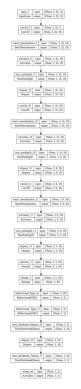

In [76]:
import matplotlib.pyplot as plt
from keras.utils import plot_model

# Assuming you already have a Keras model defined and compiled
# model = ...

# Save the model architecture to a file (e.g., model.png)
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Display the saved image using Matplotlib
img = plt.imread('model.png')
plt.imshow(img)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

In [96]:
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade

  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-6323ej5p
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-6323ej5p
  Resolved https://github.com/paulgavrikov/visualkeras to commit cd169b81be347e2090353ad6fe2bd2e1f4020cf4
  Preparing metadata (setup.py) ... done


In [99]:
pip install --upgrade visualkeras


In [100]:
import visualkeras

In [98]:
visualkeras.layered_view(model).show()

TypeError: ignored

In [83]:
import visualkeras
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(model, legend=True, font=font, draw_volume=False)
visualkeras.layered_view(model, legend=True, font=font) # selected font

TypeError: ignored

Class weights [0.85614525 1.20196078]


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

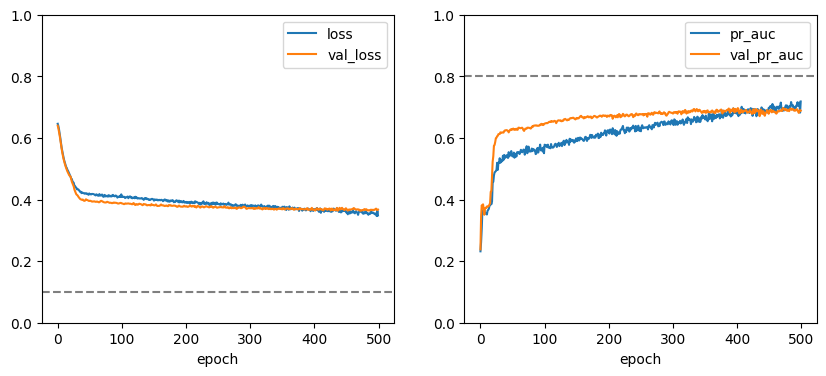

In [37]:
epochs = 500
batch_size = 10*64

from tqdm.keras import TqdmCallback

# Compute the spectral background across entire clip
# Used for spectral subtraction, a type of preprocessing/normalization technique that is often useful
Xm = np.expand_dims(np.mean(np.concatenate([s.T for s in dataset.spectrogram]), axis=0), -1)

def get_XY(split):
    # convenience to convert
    d = dataset[dataset.split == split]

    X = np.expand_dims(np.stack([(s-Xm).T for s in d.spectrogram]), -1)

    Y = np.stack([ l.T for l in d.labels], axis=0)
    return X, Y

train = get_XY(split='train')
val = get_XY(split='val')

def compute_class_weights(y_train):
    from sklearn.utils import class_weight
    y_train = np.squeeze(y_train).astype(int)
    y_train = np.any(y_train, axis=1)
    w = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    #w_dict = dict(zip(numpy.unique(y_train), w))
    return w

class_weights = compute_class_weights(train[1])
#class_weights = None # disable class weights
print('Class weights', class_weights)

# make sure to stop when model does not improve anymore / starts overfitting
early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
progress_bar = TqdmCallback()

import tensorflow.math
def schedule(epoch, lr):
    if epoch < 100:
        return lr
    else:
        return lr * tensorflow.math.exp(-0.1)

lr_callback = tensorflow.keras.callbacks.LearningRateScheduler(schedule)

#lr_callback = tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, min_lr=0.01)

model = build_model(input_shape=(window_length, 32, 1), dropout=0.10, lr=1*0.001, class_weights=class_weights)
hist = model.fit(x=train[0], y=train[1],
        validation_data=val,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[
            progress_bar,
            #lr_callback,
            #early_stop,
        ],
        verbose=False, # using progress bar callback instead
)

def plot_history(history):

    fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
    history = pd.DataFrame(hist.history)
    history.index.name = 'epoch'
    history.plot(ax=axs[0], y=['loss', 'val_loss'])
    history.plot(ax=axs[1], y=['pr_auc', 'val_pr_auc'])
    axs[1].set_ylim(0, 1.0)
    axs[1].axhline(0.80, ls='--', color='black', alpha=0.5)

    axs[0].axhline(0.10, ls='--', color='black', alpha=0.5)
    axs[0].set_ylim(0, 1.0)

plot_history(hist)

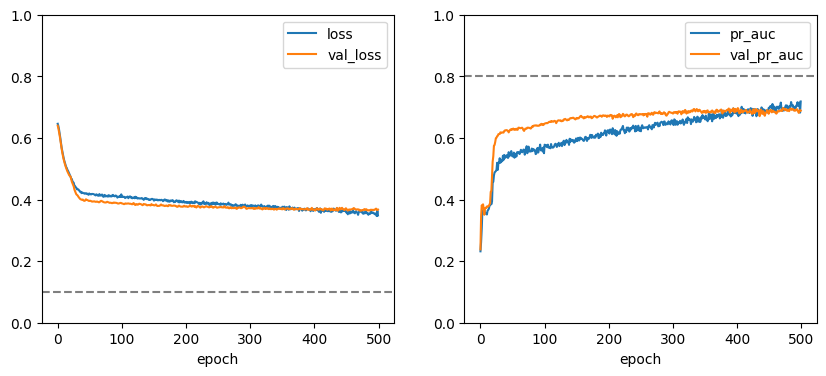

In [85]:
plot_history(hist)
plt.savefig("figure6.jpeg",dpi=800)

In [38]:
test = get_XY(split='test')

results = pd.DataFrame({
    'split': [ 'test', 'train', 'val' ],
})
def get_metric(split):
    X, Y = get_XY(split=split)
    r = model.evaluate(x=X, y=Y, return_dict=True, verbose=False)
    return pd.Series(r)

e = results.split.apply(get_metric)
results = pd.merge(results, e, right_index=True, left_index=True).set_index('split')
results

,loss,pr_auc,precision,recall
split,,,,
test,0.373502,0.654443,0.598131,0.531120
train,0.322632,0.777648,0.733542,0.619594
val,0.367266,0.688571,0.671958,0.524793
